# Assignment 2

# Karunanayaka Y.S (190301H)

Github Repository: https://github.com/YSK-Machine-Vision-EN2550/Assignment_2.git

In [1]:
import numpy as np
import matplotlib . pyplot as plt
import cv2 as cv
# from numpy.random import default_rng
rng = np.random.default_rng()

In [2]:
N = 100
half_n = N // 2
r = 10
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )

In [3]:
# calculate the best fit circle
probability = 0.99
outlier_ratio = 0.40
trsh_dist = 0.9
s = 3
Itterations = int(np.log(1-probability)/np.log(1-(1-outlier_ratio)**s))

In [4]:
def bestFitting(X_circ, Itterations, trsh_dist):
    """
    DOCSTRING: This function choose 3 random points from given X_circ array. And find the cricle through it. Then it counts
               the number of inliers using threshold given. This process will done N times(itterations)
    return:    This will return the circle with most inliers, and the array of inliers at that circle
    """
    random_circles = []
    
    for _ in range(Itterations):
        numbers = rng.choice(X_circ.shape[0], size=3, replace=False) # choose 3 random non-repeatitve numbers 
        r_points = X_circ[numbers] # extract 3 random points corresponding to numbers above
        # Extract x and y coordinates
        x, y = np.hsplit(np.array(r_points), 2) 
        x, y = x.T[0], y.T[0]
        # find the crcile through all those three points
        f = ((x[0]**2-x[1]**2+y[0]**2-y[1]**2)*(x[0]-x[2])-(x[0]**2-x[2]**2+y[0]**2-y[2]**2)*(x[0]-x[1]))/(2*((y[0]-y[2])*(x[0]-x[1])-(y[0]-y[1])*(x[0]-x[2])))
        g = ((x[0]**2-x[1]**2+y[0]**2-y[1]**2)*(y[0]-y[2])-(x[0]**2-x[2]**2+y[0]**2-y[2]**2)*(y[0]-y[1]))/(2*((y[0]-y[1])*(x[0]-x[2])-(y[0]-y[2])*(x[0]-x[1])))
        a, b, r = -g, -f, np.sqrt((x[0] + g)**2 + (y[0] + f)**2)
        # append the random circle to the list
        random_circles.append((a,b,r))
    
    max_inliers = 0
    inliers = []
    circle = []
    
    for r_c in random_circles:
        counter = 0
        inlier_points_temp = []
        # count the inliers
        for point in X_circ:
            distance = np.abs(np.sqrt((point[0] - r_c[0]) ** 2 + (point[1] - r_c[1]) ** 2) - r_c[2])
            if distance < trsh_dist:
                counter += 1
                inlier_points_temp.append(point)
         # if found a new maximum number of inliers update the best fitting circle and inliers
        if counter > max_inliers:
            max_inliers = counter
            inliers = inlier_points_temp
            circle = r_c
            
    return circle, np.array(inliers)

In [18]:
# Do ransac fitting
circle1, inliers1 = bestFitting(X_circ, Itterations, trsh_dist)
circle2, inliers2 = bestFitting(inliers1, Itterations, trsh_dist)

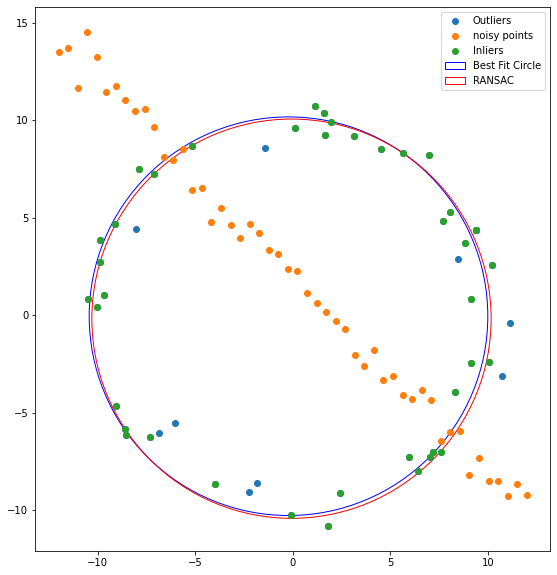

In [19]:
figure, axes = plt.subplots(figsize = (10,10))
axes.plot(X_circ[:,0],X_circ[:,1],'o',label = 'Outliers')
axes.plot(X_line[:,0],X_line[:,1],'o',label = 'noisy points')
axes.plot(inliers1[:,0], inliers1[:, 1], 'o',label = 'Inliers')

circle_1 = plt.Circle((circle1[0], circle1[1]),circle1[2],fill = False,color = 'blue',label = 'Best Fit Circle')
circle_2 = plt.Circle((circle2[0], circle2[1]),circle2[2],fill = False,color = 'red',label = 'RANSAC')

axes.set_aspect(1)
axes.add_artist(circle_1)
axes.set_aspect( 1 )
axes.add_artist(circle_2)

plt.legend()
plt.show()

## Question 2

In [7]:
def mousePoint(event, x,y,flags,params):
    """
    DOCSTRING: This function will take the coordinates of the mouse click when we pressed the button and
               append that point to the imgPoints array
    """
    if event == cv.EVENT_LBUTTONDOWN:
        imgPoints.append([x,y,1])
        
def findHomography(imgPoints, warpingImg, given_points = False):
    """
    DOCSTRING: This function will take two arrays of points then find the Homography matrix accordingly
    return: Homography Matrix
    """
    # XT is source
    if given_points:
        XT = warpingImg # if a array of points given XT <= given array
    else: # if a image is given find four corners
        XT = np.array(
            [[0,0,1], [warpingImg.shape[1] - 1, 0, 1], [warpingImg.shape[1] - 1, warpingImg.shape[0] - 1, 1], [0, warpingImg.shape[0] - 1, 1]], dtype = np.float64
        )

    OT = np.array([0,0,0], dtype = np.float64) # the zero vector
    # IP destination 
    IP = np.array(imgPoints).astype(np.float64)
    A = np.zeros((1, 9), dtype = np.float64)
    # find A
    for i in range(XT.shape[0]):
        B = np.array(
            [np.concatenate((OT, XT[i], -IP[i][1] * XT[i]), axis = 0),
             np.concatenate((XT[i], OT, -IP[i][0] * XT[i]), axis = 0)], dtype = np.float64
        )
        A = np.concatenate((A, B), axis = 0)

    A = A[1:]
    W, V = np.linalg.eig(A.T @ A) # get eigen values and vectors
    H = V[:, np.where(W == np.min(W))[0][0]].reshape(3,3)  
    return H

Text(0.5, 1.0, 'Overlayed Image')

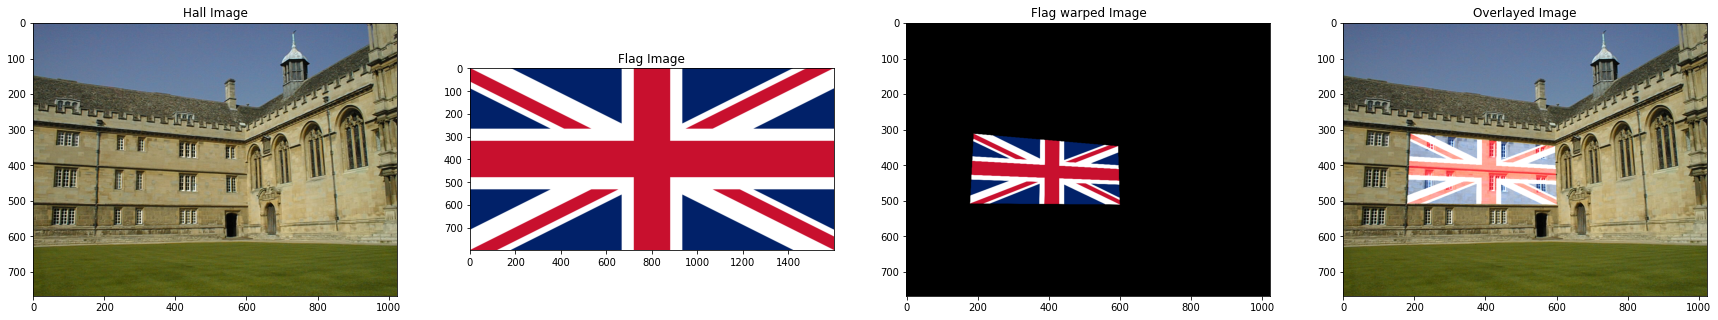

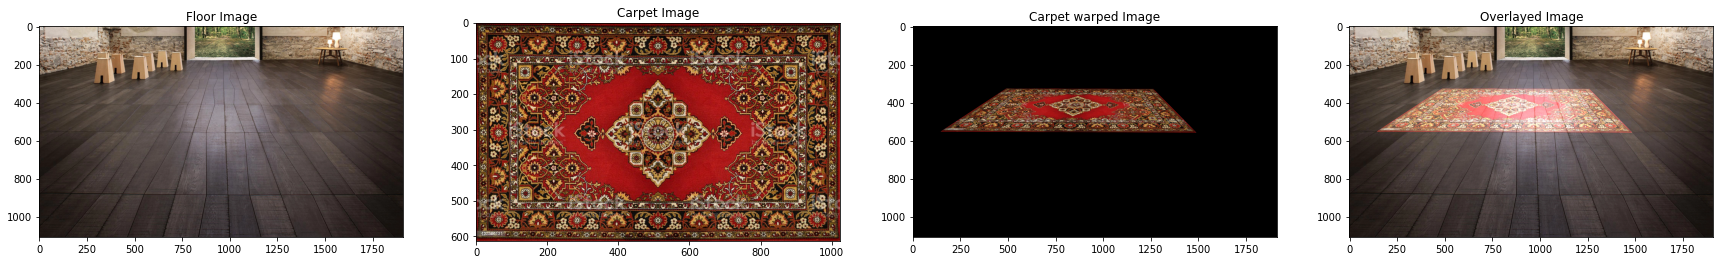

In [24]:
imgPoints = [] # clicked coordinates will append to this lits
hall = cv.imread("003.jpg") # read the Hall image
UK = cv.imread("UK.png") # read the UK flag
cv.imshow('ImageWindow', hall)
cv.setMouseCallback('ImageWindow',mousePoint)
cv.waitKey(0)

H = findHomography(imgPoints, UK) # find homography using above function
new_img = cv.warpPerspective(UK, H, hall.shape[1::-1]) # do warping
overlayed_img = cv.add(hall, new_img) # overlay the warped image on top of the hall image
cv.imshow("warped and overlayed", overlayed_img)
cv.waitKey(0)

fig, ax = plt.subplots(1, 4, figsize = (30, 15))
ax[0].imshow(cv.cvtColor(hall, cv.COLOR_BGR2RGB))
ax[0].set_title("Hall Image")
ax[1].imshow(cv.cvtColor(UK, cv.COLOR_BGR2RGB))
ax[1].set_title("Flag Image")
ax[2].imshow(cv.cvtColor(new_img, cv.COLOR_BGR2RGB))
ax[2].set_title("Flag warped Image")
ax[3].imshow(cv.cvtColor(overlayed_img, cv.COLOR_BGR2RGB))
ax[3].set_title("Overlayed Image")

imgPoints = [] # clicked coordinates will append to this lits
hall = cv.imread("imgs/floor.webp") # read the Hall image
UK = cv.imread("imgs/carpet.jpg") # read the UK flag
cv.imshow('ImageWindow', hall)
cv.setMouseCallback('ImageWindow',mousePoint)
cv.waitKey(0)

H = findHomography(imgPoints, UK) # find homography using above function
new_img = cv.warpPerspective(UK, H, hall.shape[1::-1]) # do warping
overlayed_img = cv.add(hall, new_img) # overlay the warped image on top of the hall image
cv.imshow("warped and overlayed", overlayed_img)
cv.waitKey(0)

fig, ax = plt.subplots(1, 4, figsize = (30, 15))
ax[0].imshow(cv.cvtColor(hall, cv.COLOR_BGR2RGB))
ax[0].set_title("Floor Image")
ax[1].imshow(cv.cvtColor(UK, cv.COLOR_BGR2RGB))
ax[1].set_title("Carpet Image")
ax[2].imshow(cv.cvtColor(new_img, cv.COLOR_BGR2RGB))
ax[2].set_title("Carpet warped Image")
ax[3].imshow(cv.cvtColor(overlayed_img, cv.COLOR_BGR2RGB))
ax[3].set_title("Overlayed Image")

## Question 3

In [9]:
# read all the graffity images from the folder
img = np.array([cv.imread("graf/img{}.ppm".format(i)) for i in range(1, 6)])

In [10]:
def getSIFTpoints(img_arr, index1, index2):
    """
    DOCSTRING: this function will do SIFT matching and return two pairs of coordinate array of SIFT features
    """
    sift = cv.xfeatures2d.SIFT_create()
    
    keypts1, descriptors1 = sift.detectAndCompute(img_arr[index1], None)
    keypts2, descriptors2 = sift.detectAndCompute(img_arr[index2], None)
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(descriptors1,descriptors2,k=2)
    
    pts1 = []
    pts2 = []

    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            pts1.append(keypts1[m.queryIdx].pt)
            pts2.append(keypts2[m.trainIdx].pt)
            
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    return pts1,pts2

def RANSAC_SIFT_features(pts1, pts2, threshold):
    """
    DOCSTRING: this function will get two pairs of SIFT feature point arrays and a threshhold. Then it will select 4 random
               pairs of points and generate Homograpy. Then it will convert all the source points new_desitanation points. 
               Then it will save the pairs within the given threshold value
    return:    Saved pairs of points
    """
    max_inliers = 0
    inlierpts1 = []
    inlierpts2 = []
    # appand 1 to each row
    pts1 = np.hstack((pts1, np.ones(pts1.shape[0]).reshape(-1, 1)))
    pts2 = np.hstack((pts2, np.ones(pts2.shape[0]).reshape(-1, 1)))
    
    for i in range(Itterations):

        numbers = rng.choice(pts1.shape[0], size=4, replace=False) # randomly coose 4 non repeative numbers
        r_points1, r_points2 = pts1[numbers], pts2[numbers] # get corresponding points for above numbers
        H = findHomography(r_points2, r_points1, given_points=True) # find the homography
        # convert all source points to new_destination points
        new_points = []
        for j in range(pts1.shape[0]):
            point = H @ pts1[j]
            point = point / point[2]
            new_points.append(point)

        new_points = np.array(new_points)
        diff = new_points[:, :-1] - pts2[:, :-1] # calculate the difference 
        ssds = np.sqrt(np.sum(np.power(diff, 2), axis = 1)) # then find the sqrt of sum of squares

        temp_inlier_count = 0
        temp_pts1 = []
        temp_pts2 = []

        for index, ssd in enumerate(ssds):
            if ssd < threshold: # if the new_destinaltion and destination close enought save it
                temp_inlier_count += 1
                temp_pts1.append(pts1[index])
                temp_pts2.append(pts2[index])

        if temp_inlier_count > max_inliers: # if you found a new most suitable homography then update the inliers
            max_inliers = temp_inlier_count
            inlierpts1 = temp_pts1
            inlierpts2 = temp_pts2

    return np.array(inlierpts1), np.array(inlierpts2)

In [11]:
threshold = 1 # set threshold to 1
Homographies = []
# find the corresponding Homograpy matrixes to warp (img1 -> img2), (img2 -> img3), (img3-> img4), (img4 -> img5)
for i in range(4):
    pts1, pts2 = getSIFTpoints(img, i, i + 1)
    pts1, pts2 = RANSAC_SIFT_features(pts1, pts2, threshold)
    H = findHomography(pts2, pts1, given_points=True)
    
    Homographies.append(H)

In [12]:
# we need to multiply H matrixes from the reverse direction
H = Homographies[3]
for i in range(4)[2::-1]:
    H = H @ Homographies[i]

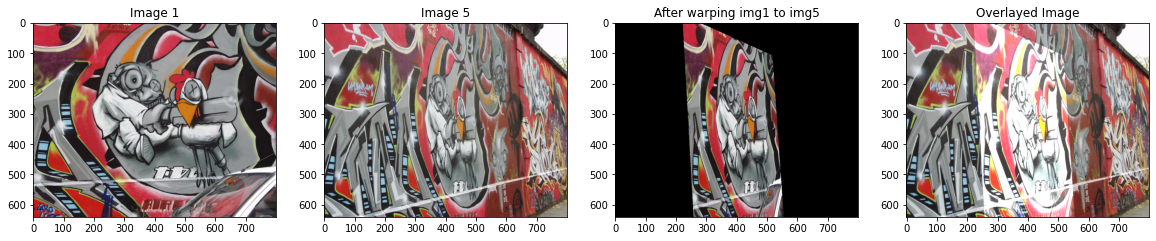

In [15]:
new_img = cv.warpPerspective(img[0], H, img[4].shape[1::-1]) # Do warping

cv.imshow("Added", cv.add(img[4], new_img))
cv.waitKey(0)

fig, ax = plt.subplots(1, 4, figsize = (20, 5))
ax[0].imshow(cv.cvtColor(img[0], cv.COLOR_BGR2RGB))
ax[0].set_title("Image 1")
ax[1].imshow(cv.cvtColor(img[4], cv.COLOR_BGR2RGB))
ax[1].set_title("Image 5")
ax[2].imshow(cv.cvtColor(new_img, cv.COLOR_BGR2RGB))
ax[2].set_title("After warping img1 to img5")
ax[3].imshow(cv.cvtColor(cv.add(img[4], new_img), cv.COLOR_BGR2RGB))
ax[3].set_title("Overlayed Image")
plt.show()